In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM

from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
import cv2


In [2]:
# Load data
train = pd.read_csv('/Users/harshatummala/Downloads/data/train.csv')
test = pd.read_csv('/Users/harshatummala/Downloads/data/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
test['diagnosis'] = test['diagnosis'].astype('str')
display(train.head())
display(test.head())

Number of train samples:  2929
Number of test samples:  733


id_code  age gender diagnosis
0  e8ddfc9709ce.png   55      F         0
1  c1437a7a52c9.png   64      F         0
2  b8ebedd382de.png   31      M         1
3  9859e2a6cc24.png   62      M         4
4  66b88a4bc474.png   78      F         0

id_code  age gender diagnosis
0  04aef84a2cc1.png   75      F         0
1  4ad8d3ec8789.png   26      F         0
2  cb02bb47fdc5.png   71      F         0
3  c9d42d7534e0.png   70      M         2
4  d5a39339ff3d.png   19      F         2

In [3]:
# Model parameters
BATCH_SIZE = 8
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES = test['diagnosis'].nunique()

In [4]:
# Data generators

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/Users/harshatummala/Downloads/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/Users/harshatummala/Downloads/data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0)


Found 2926 validated image filenames belonging to 5 classes.
Found 731 validated image filenames belonging to 5 classes.


/Users/harshatummala/miniconda3/envs/diabetic-retinopathy/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/Users/harshatummala/miniconda3/envs/diabetic-retinopathy/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [35]:
# Generate 20 test data points

test_generator.batch_size = 20 # background dataset
data, labels = next(test_generator)

test_generator.batch_size = 100 # background dataset
data_bg = next(test_generator)

[1. 0. 0. 0. 0.]


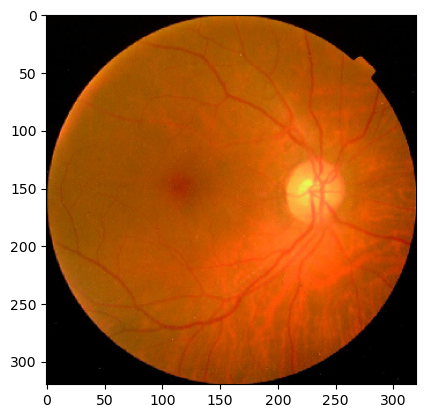

[1. 0. 0. 0. 0.]


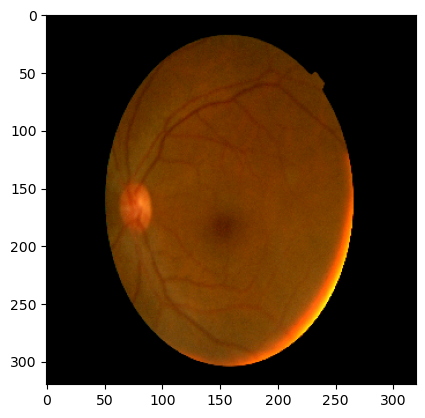

[1. 0. 0. 0. 0.]


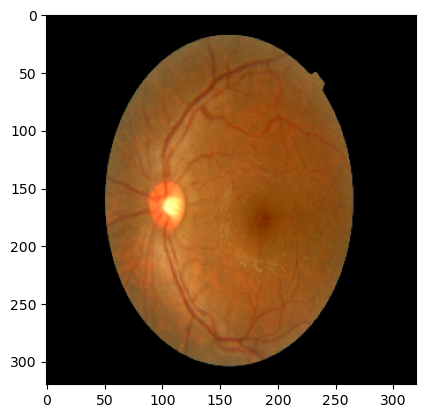

[0. 0. 1. 0. 0.]


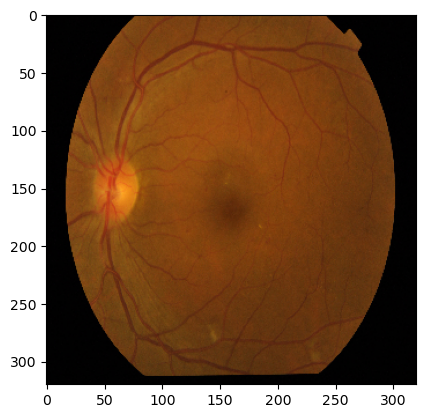

[1. 0. 0. 0. 0.]


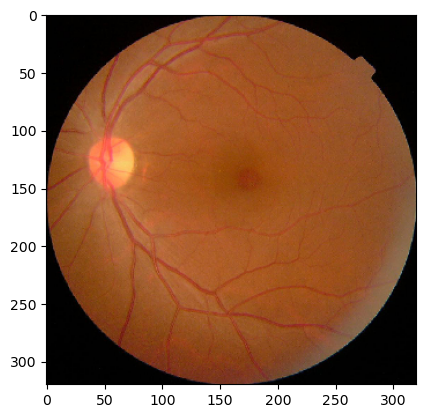

In [61]:
# View some images and labels

plt.imshow(data[0])
print(labels[0])
plt.show()

plt.imshow(data[1])
print(labels[1])
plt.show()

plt.imshow(data[2])
print(labels[2])
plt.show()

plt.imshow(data[3])
print(labels[3])
plt.show()

plt.imshow(data[4])
print(labels[4])
plt.show()

In [46]:
# Load model
model = tf.keras.models.load_model("/Users/harshatummala/Downloads/model.h5")


731/731 [==============================] - 56s 76ms/step


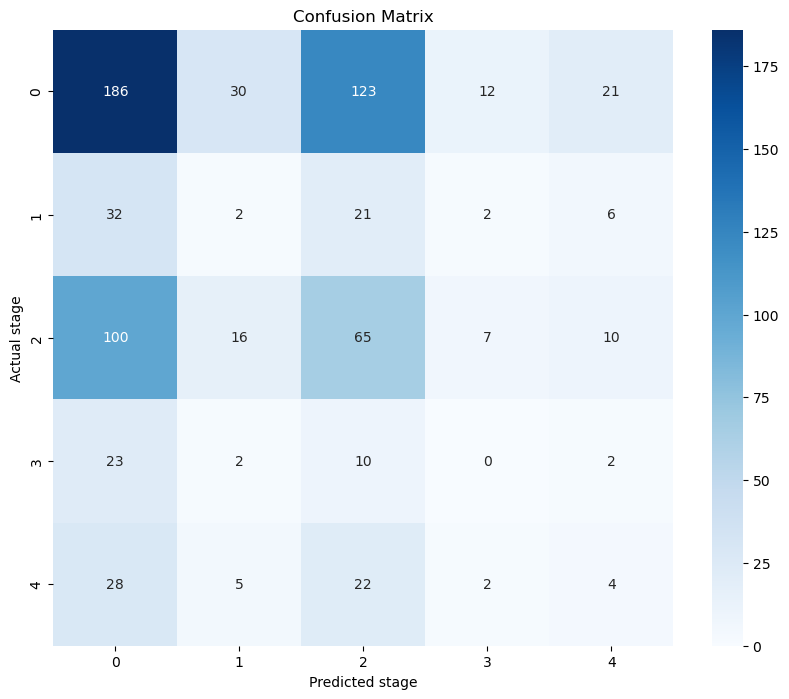

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       372
           1       0.04      0.03      0.03        63
           2       0.27      0.33      0.30       198
           3       0.00      0.00      0.00        37
           4       0.09      0.07      0.08        61

    accuracy                           0.35       731
   macro avg       0.18      0.19      0.18       731
weighted avg       0.34      0.35      0.35       731

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_1[0][0]']             

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'model' is your trained model and 'test_generator' is configured to use all test data
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=1)

# Generate a confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(10, 8))
confusion_main = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual stage')
plt.xlabel('Predicted stage')
plt.show()

# Display classification report
print(classification_report(test_generator.classes, predicted_classes))

# Feature importance or model summary
model.summary()

In [38]:
# Ignore this part

# import shap
# import numpy as np
# import tensorflow as tf
# 
# explainer_shap = shap.DeepExplainer(model, data_bg[0][:100])  # Using a background dataset
# 
# # Generate SHAP values for a subset of the data
# shap_values = explainer_shap.shap_values(data_bg[0][:10])
# 
# # Plot SHAP values for the first prediction
# shap_plot = shap.image_plot(shap_values, data[:10])
# plt.imshow(shap_plot)
# plt.show()
# 
# shap_values_full = explainer_shap.shap_values(data[:10])
# 
# # Generate a summary plot
# shap_full = shap.summary_plot(shap_values_full, data)
# plt.imshow(shap_full)
# plt.show()

ModuleNotFoundError: No module named 'shap'

In [91]:
explainer = GradCAM()

In [92]:
test_generator.batch_size = 1 #  dataset for heatmap generation
data1, labels1 = next(test_generator)

data2, labels2 = next(test_generator)

data3, labels3 = next(test_generator)

In [93]:
# Generate some predictions
predictions = model.predict(data).argmax(axis=1)
class_index = predictions[0]

predictions1 = model.predict(data1).argmax(axis=1)
class_index1 = predictions1[0]

predictions2 = model.predict(data2).argmax(axis=1)
class_index2 = predictions2[0]

predictions3 = model.predict(data3).argmax(axis=1)
class_index3 = predictions3[0]


1/1 [==============================] - 0s 83ms/step


In [94]:
predictions_master = model.predict(data)
import numpy as np
predicted_class_indices = np.argmax(predictions_master, axis=1)  # Indices of predicted classes
confidences = np.max(predictions_master, axis=1)
print(confidences)
print(predicted_class_indices)

1/1 [==============================] - 1s 1s/step
[0.99887663 0.9999893  0.99998343 0.803426   0.9998023  0.3478287
 0.99998903 0.99698657 0.9999707  0.4090524  0.9999974  0.8564589
 0.86540323 0.9989618  0.7850521  0.99974686 0.8246745  0.99889106
 0.99928856 0.8653278 ]
[0 0 0 2 0 4 0 0 0 3 0 2 0 4 2 0 1 0 0 3]


[[[174 221  48]
  [174 221  48]
  [174 220  48]
  ...
  [ 32 161 136]
  [ 33 162 136]
  [ 32 162 136]]

 [[174 221  48]
  [174 221  48]
  [176 222  49]
  ...
  [ 32 161 136]
  [ 33 162 136]
  [ 32 162 136]]

 [[174 221  48]
  [174 221  48]
  [174 220  48]
  ...
  [ 32 162 136]
  [ 32 162 136]
  [ 32 162 136]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


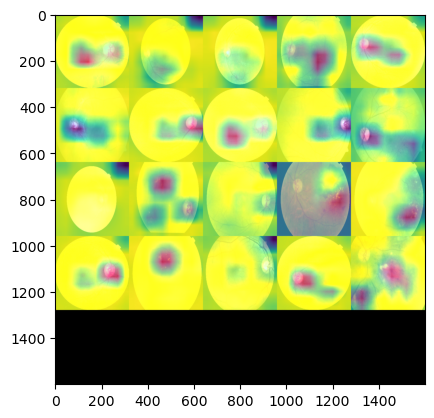

[0.99887663 0.9999893  0.99998343 0.803426   0.9998023  0.3478287
 0.99998903 0.99698657 0.9999707  0.4090524  0.9999974  0.8564589
 0.86540323 0.9989618  0.7850521  0.99974686 0.8246745  0.99889106
 0.99928856 0.8653278 ]
0
0.99887663
[1. 0. 0. 0. 0.]


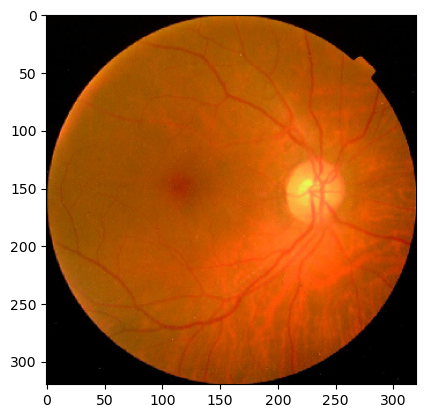

0
0.9999893
[1. 0. 0. 0. 0.]


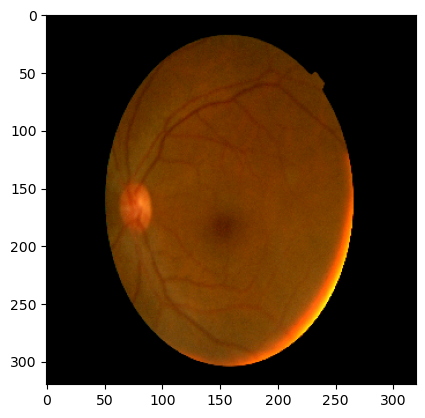

0
0.99998343
[1. 0. 0. 0. 0.]


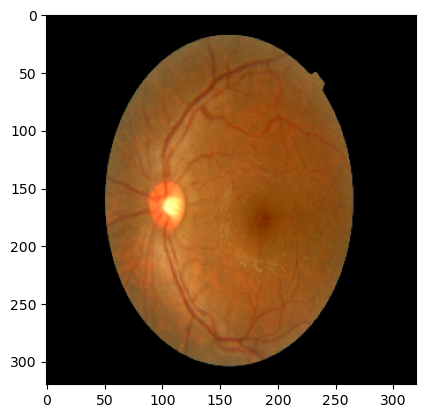

2
[0. 0. 1. 0. 0.]


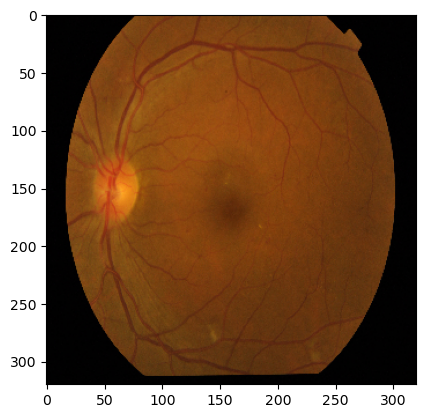

0
[1. 0. 0. 0. 0.]


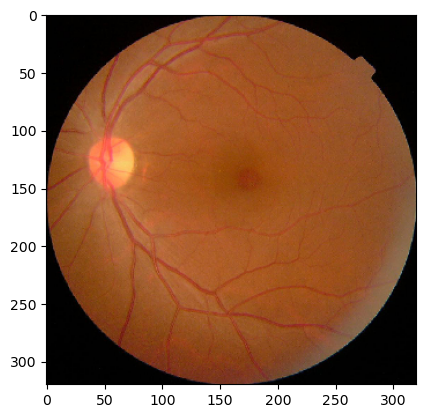

In [95]:
# View some predictions
heatmap = explainer.explain((data, None), model, class_index,layer_name='res5c_branch2c')
print(heatmap)
plt.imshow(heatmap)
plt.show()

predicted_class_indices = np.argmax(predictions_master, axis=1)  # Indices of predicted classes
confidences = np.max(predictions_master, axis=1)
print(confidences)
plt.imshow(data[0])
print(predictions[0])
print(confidences[0])
print(labels[0])
plt.show()


plt.imshow(data[1])
print(predictions[1])
print(confidences[1])
print(labels[1])
plt.show()

plt.imshow(data[2])
print(predictions[2])
print(confidences[2])
print(labels[2])
plt.show()

plt.imshow(data[3])
print(predictions[3])
print(labels[3])
plt.show()

plt.imshow(data[4])
print(predictions[4])
print(labels[4])
plt.show()

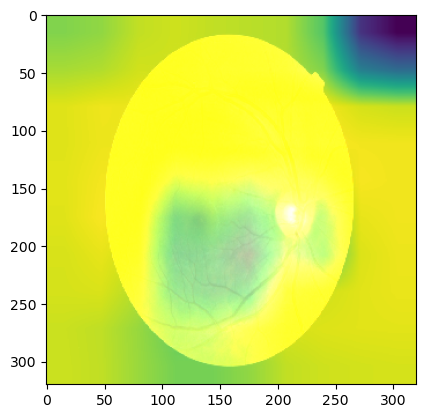

1/1 [==============================] - 0s 100ms/step
0
0.99998534
[1. 0. 0. 0. 0.]


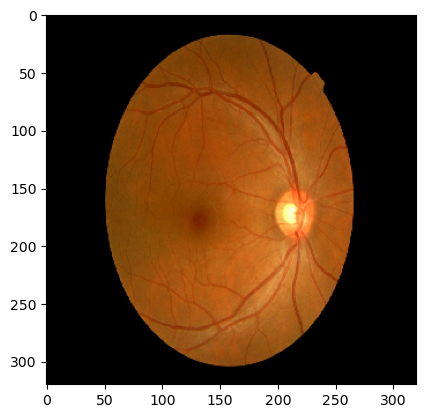

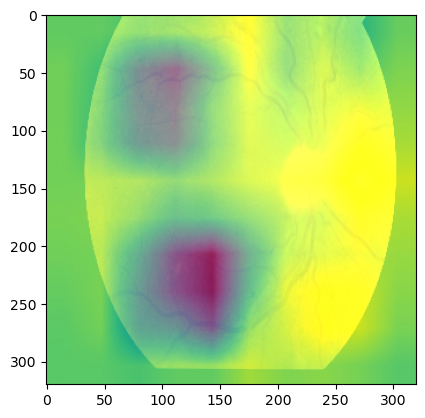

1/1 [==============================] - 0s 117ms/step
2
0.6636029
[0. 0. 1. 0. 0.]


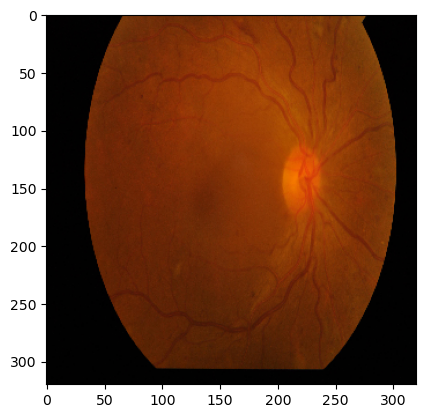

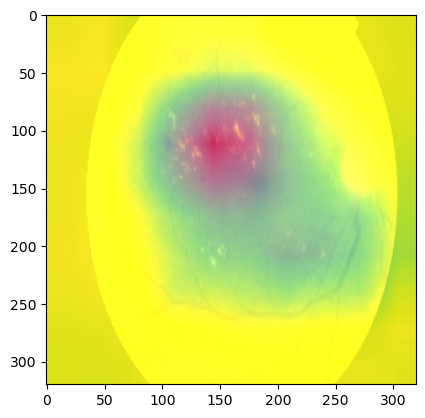

1/1 [==============================] - 0s 104ms/step
2
0.8954763
[0. 0. 0. 0. 1.]


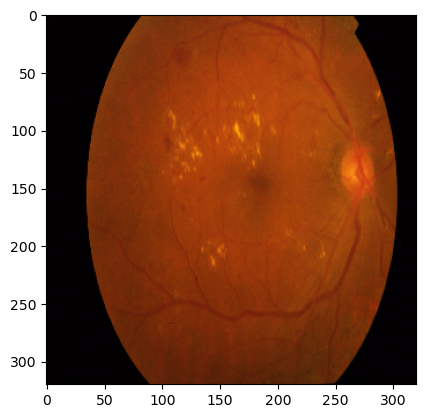

In [96]:
heatmap1 = explainer.explain((data1, None), model, class_index1,layer_name='res5c_branch2c')
plt.imshow(heatmap1)
plt.show()

predictions_master1 = model.predict(data1)
confidences1 = np.max(predictions_master1, axis=1)
plt.imshow(data1[0])
print(predictions1[0])
print(confidences1[0])
print(labels1[0])
plt.show()

heatmap2 = explainer.explain((data2, None), model, class_index2,layer_name='res5c_branch2c')
plt.imshow(heatmap2)
plt.show()

predictions_master2 = model.predict(data2)
confidences2 = np.max(predictions_master2, axis=1)
plt.imshow(data2[0])
print(predictions2[0])
print(confidences2[0])
print(labels2[0])
plt.show()

heatmap3 = explainer.explain((data3, None), model, class_index3,layer_name='res5c_branch2c')
plt.imshow(heatmap3)
plt.show()

predictions_master3 = model.predict(data3)
confidences3 = np.max(predictions_master3, axis=1)
plt.imshow(data3[0])
print(predictions3[0])
print(confidences3[0])
print(labels3[0])
plt.show()


1/1 [==============================] - 0s 89ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


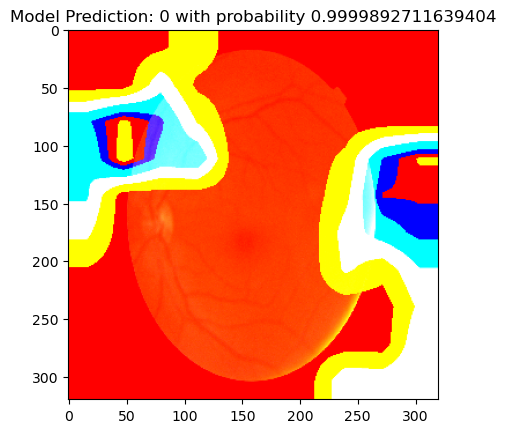

In [75]:
# IGNORE THIS

import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
import numpy as np

def grad_cam(model, img_path, layer_name='res5c_branch2c'):
    """
    This function generates a heatmap for a specific image with respect to the output of the model.
    """
    img = img_path
    img = np.expand_dims(img, axis=0)
    # img /= 320.

    preds = model.predict(img)
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_output = iterate(img)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((last_conv_output.shape[1], last_conv_output.shape[2]))

    img = img_path
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(320*heatmap), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('/mnt/data/grad_cam_output.jpg', superimposed_img)
    plt.imshow(superimposed_img)
    plt.title(f"Model Prediction: {np.argmax(preds)} with probability {np.max(preds)}")
    plt.show()

# Example use:
img = data[1]
grad_cam(model, img)


In [121]:
 # Generate explanations

explanation_model = ("""<div>
    <h3>Model Performance Overview</h3>
    <h4>Model Accuracy:</h4>
    <ul>
        <li><strong>Overall Accuracy:</strong> The model achieves an accuracy of 35%, which indicates its effectiveness in correctly identifying the stages of diabetic retinopathy from retinal images. The low accuracy is because of the separation between various stages of DR that is provided.</li>
    </ul>
    <h4>Confusion Matrix Analysis:</h4>
    <p>It shows the distribution of cases identifies across all types contrasted with the actual stage of DR.</p>
    <h3>Discussion:</h3>
    <p>The presence of false negatives and false positives underscores the need for continuous model training and improvement, especially in enhancing the model's ability to detect more subtle signs of the condition. Future iterations of the model will focus on reducing these errors by incorporating more diverse data and improving the algorithm’s feature detection capabilities.</p>
</div>
"""
)
explanation_data = """
<div>
    <h3>Data Overview:</h3>
    <ul>
        <li><strong>Training Dataset:</strong> Consists of 2,929 entries.</li>
        <li><strong>Testing Dataset:</strong> Consists of 733 entries.</li>
        <li><strong>Columns:</strong> Each dataset includes the following columns:
            <ul>
                <li><code>id_code</code>: Unique identifier for each patient.</li>
                <li><code>age</code>: Age of the patient.</li>
                <li><code>gender</code>: Gender of the patient (Male or Female).</li>
                <li><code>diagnosis</code>: Diagnosis results, encoded as integers representing different stages of diabetic retinopathy.</li>
            </ul>
        </li>
    </ul>
    <h3>Data Description for Global Explanation Page:</h3>
    <ol>
        <li><strong>Purpose of the Data:</strong>
            <p>The datasets are used to train and validate a machine learning model designed to detect different stages of diabetic retinopathy from images of the retina. The model helps in preliminary screening and assists healthcare providers in diagnosis.</p>
        </li>
        <li><strong>Data Collection:</strong>
            <p>The data comprises demographic information (age, gender) and diagnosis results.</p>
        </li>
        <li><strong>Integrity and Privacy:</strong>
            <p>The data is anonymized to protect patient privacy, with each entry represented by a unique identifier rather than personal information. Measures are taken to ensure data integrity and relevance to the condition being screened.</p>
        </li>
        <li><strong>Use of Data:</strong>
            <p>The training data is used to teach the model to recognize signs of diabetic retinopathy in retinal images based on known outcomes. The testing data evaluates the model's accuracy and ability to generalize to new, unseen cases.</p>
        </li>
        <li><strong>Limitations:</strong>
            <p>The data might not cover all demographics equally, which could affect the model's performance across different population groups. The stages of diabetic retinopathy are encoded numerically; 0: 'No signs', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative signs'.</p>
        </li>
    </ol>
</div>
"""
# ...

def generate_dynamic_explanation(prediction_class, probability):
    """
    Generate a tailored explanation based on the prediction class, probability, and detected features.
    
    Parameters:
    - prediction_class (str): The class of the prediction (e.g., 'No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR').
    - probability (float): The probability associated with the prediction.
    - features (list): A list of clinically relevant features detected in the image.
    
    Returns:
    - str: A comprehensive explanation suitable for the end user.
    """
    base_text = f"The analysis is consistent with {diagnosis_dict[prediction_class]} diabetic retinopathy detected, with a confidence of {probability*100:.2f}%. "
    # feature_text = f"Key features influencing this diagnosis include: {', '.join(features)}. "

    if prediction_class == 0:
        advice_text = "Regular screening is recommended to monitor changes."
    elif prediction_class == 1:
        advice_text = "It is advisable to monitor your eye health regularly and consult an ophthalmologist."
    elif prediction_class == 2:
        advice_text = "Consultation with an ophthalmologist is recommended for potential treatment options."
    elif prediction_class == 3:
        advice_text = "Immediate consultation with an ophthalmologist is strongly recommended to prevent progression."
    elif prediction_class == 4:
        advice_text = "A severe form of DR requiring immediate medical attention."
    else:
        advice_text = "Please consult a healthcare professional for a comprehensive assessment."
        
    image_compare = "The Models view of image shows the areas of the actual image that the model used, to come up with the aforementioned prognosis."

    return base_text + advice_text + image_compare

# features = ["vascular abnormalities", "microaneurysms", "exudates"]
explanation_text = generate_dynamic_explanation(predictions[0], confidences[0])
print(explanation_text)


The analysis is consistent with No signs diabetic retinopathy detected, with a confidence of 99.89%. Regular screening is recommended to monitor changes.The Models view of image shows the areas of the actual image that the model used, to come up with the aforementioned prognosis.


In [122]:
diagnosis_dict = {0: 'No signs of',
                  1: 'Mild',
                  2: 'Moderate',
                  3: 'Severe',
                  4: 'Proliferative signs of'}

In [115]:
# generator for html template

def generate_html_general(name, data_image, prediction, explanation_model, explanation_data):
      html = open("global_explanation_template.html").read()
      
      plt.figure(figsize=(10, 8))
      confusion_main = sns.heatmap(data_image, annot=True, fmt='d', cmap='Blues')
      plt.title('Confusion Matrix')
      plt.ylabel('Actual stage')
      plt.xlabel('Predicted stage')
      #plt.title("Prediction: %s" % (prediction))
      plt.savefig('IMAGE_FOR_DISPLAY1.png')

      html = html.replace("EXPLANATION", explanation_model + explanation_data)

      with open(name, "w") as fp:
          fp.write(html)

In [123]:
# generator for html template

def generate_html_individual(name, image, data_image, prediction, explanation):
      html = open("explanation_template.html").read()


      html = html.replace("PXX", "John Doe")
      html = html.replace("GXX", "Male")
      html = html.replace("GXX", "Male")

      plt.imshow(image)
      #plt.title("Prediction: %s" % (prediction))
      plt.savefig('IMAGE_FOR_DISPLAY.png')
      
      plt.imshow(data_image)
      #plt.title("Prediction: %s" % (prediction))
      plt.savefig('IMAGE_FOR_DISPLAY1.png')


      html = html.replace("DXX", diagnosis_dict[prediction])
      html = html.replace("EXPLANATION", explanation)

      with open(name, "w") as fp:
          fp.write(html)

0


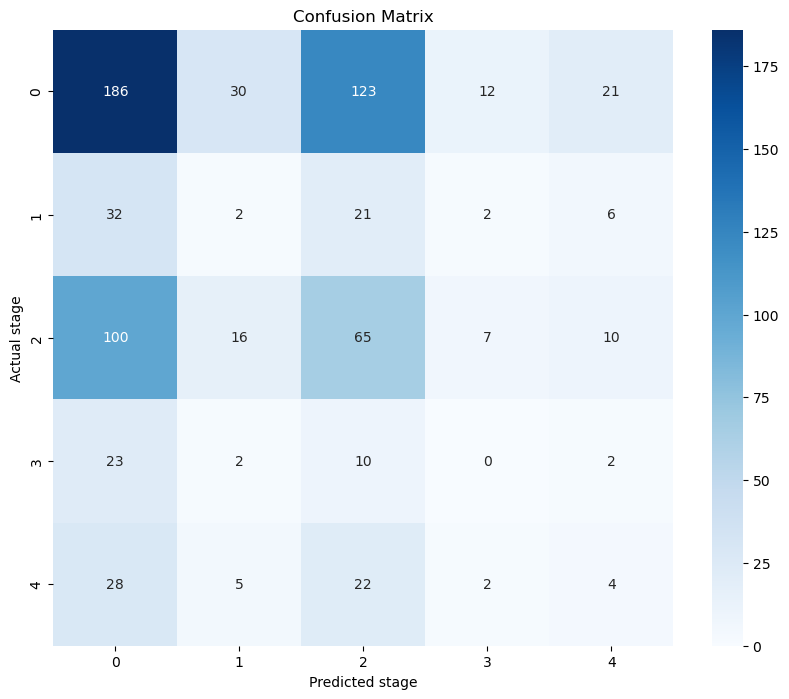

In [116]:
print(predictions[0])
generate_html_general("global.html", conf_matrix, predictions[0], explanation_model, explanation_data)

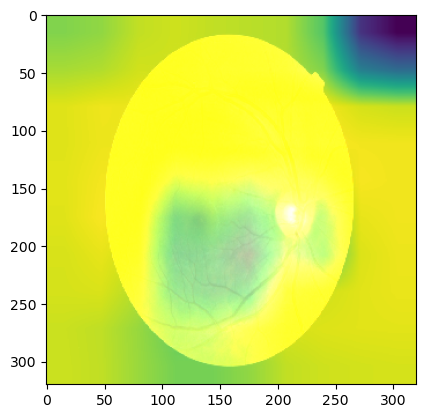

In [124]:
# Populate the html template

explanation_text1 = generate_dynamic_explanation(predictions1[0], confidences1[0])
explanation_text2 = generate_dynamic_explanation(predictions2[0], confidences2[0])
explanation_text3 = generate_dynamic_explanation(predictions3[0], confidences3[0])

generate_html_individual("individual1.html", data1[0], heatmap1, predictions1[0], explanation_text1)


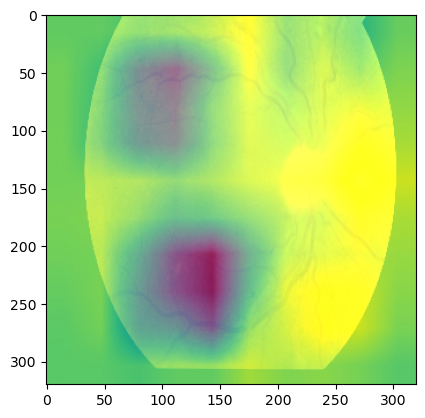

In [125]:
generate_html_individual("individual2.html", data2[0], heatmap2, predictions2[0], explanation_text2)


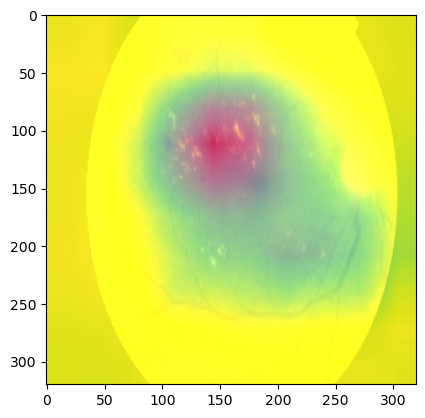

In [126]:
generate_html_individual("individual3.html", data3[0], heatmap3, predictions3[0], explanation_text3)